# Biodiversity Intactness Index Change in Phoenix Subdivision 
Author: Kristina Glass

Link to repository: https://github.com/kristinaglass/maricopa_county_biodiversity_index

# About

## Purpose

The purpose of this exploration is to find the changes in the Biodiversity Intactness Index around the Phoenex area from 2017 - 2020 [2](https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf)

## Data Description

The datasets used include:
- [The Biodiversity STAC Collection accessed from the Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/dataset/io-biodiversity).
This dataset is build on pasts datasets of spatially referenced biodiversity observations 32,000 sites from over 750 studies. The two metrics that make up Biodiversity Intactness include: Abundance (quantity of individuals) and Compositional Similarity (the similarity between the current composition of species and their intact baseline).
- [Arizona 2022 Tiger Line Shapefile accessed from the US Census Bureau](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions)
This dataset will be subset to identify the Phoenix subdivision within Maricopa County

## Highlights of Analysis

- 2. Geographic Context
- 4. Analysis
- 5. Final Output

## References

Microsoft Planetary Computer (2023). Biodiversity Intactness Index STAC Collection [Data Set]. Retrieved from https://planetarycomputer.microsoft.com/api/stac/v1/collections/io-biodiversity

US Census Bureau, 2022 TIGER/Line® Shapefiles: County Subdivisions (2022). Arizona [Data file]. Retrieved from https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions


## 1. Importing Data and Loading Datatsets

To load in the BII data, it must be access from the STAC Catelog. To import te correct dataset, having the correct coordinates and time frame for the data is necessary

In [1]:
# Import Necessary Datasets

import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from shapely.geometry import Polygon

# for MPC's STAC catalog search
import pystac_client
# used to sign items from the MPC STAC catalog
import planetary_computer

import contextily as ctx #for adding basemaps

#libraries for nice ouputs
from IPython.display import Image

In [3]:
# read in data from STAC catalog
# open catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# coords defining bbox
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# search 
search_2017 = catalog.search(
    collections=["io-biodiversity"], 
    bbox=bbox, 
    datetime='2017'
)

# get items from search
items_2017 = search_2017.item_collection()

#check collection asset
biodiversity_collection_2017 = catalog.get_child('io-biodiversity')

#check asset of item
item_2017 = items_2017[0]

#access raster
bio_index_2017 = rioxr.open_rasterio(item_2017.assets['data'].href)

In [4]:
#access 2020 raster
# search 
search_2020 = catalog.search(
    collections=["io-biodiversity"], 
    bbox=bbox, 
    datetime='2020'
)

# get items from search
items_2020 = search_2020.item_collection()

#check collection asset
biodiversity_collection_2020 = catalog.get_child('io-biodiversity')
biodiversity_collection_2020

#check asset of item
item_2020 = items_2020[0]
item_2020.assets

#access raster
bio_index_2020 = rioxr.open_rasterio(item_2020.assets['data'].href)

In [5]:
#load in arizona counties datas
arizona = gpd.read_file('data/tl_2022_04_cousub/tl_2022_04_cousub.shp')

#-----subset to Maricopa County

#use str.to.lower to make column names lowercase
arizona.columns = arizona.columns.str.lower()

#selecting Maricopa County
phoenix = arizona[arizona['name']=='Phoenix']

## 2. Geographic Context

In 2021, Maricopa County, which encompasses the Phoenix Metropolitan area, had the most land development of any US county since 2001 [1](https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/). The county added over 270 sq. miles of developed land which creates pressure on the areas biodiversity and natural landscape. While increased development and urbanization can be necessary to support growing populations within the area, it is important to consider the potential impacts of this expansion on the environment.


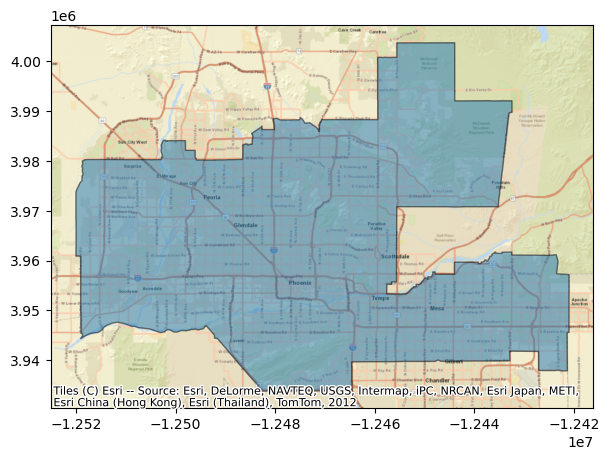

In [6]:
#plot geographic context of phoenix subdivision
# create axis with plot
ax = (phoenix.to_crs(epsg=3857) #3857 is a projected coordinate system used for rendering maps online
      .plot(figsize=(7, 7), alpha=0.5, edgecolor="k")
      )

# add basemap from contextily
# add World Street Map basemap from Esri
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldStreetMap)

## 3. Data Exploration

In [7]:
#show type of bio_index
type(bio_index_2017)
#show values of bio_index
bio_index_2017.values
#print bio_index crs
bio_index_2017.rio.crs

#show type of bio_index
type(bio_index_2020)
#show values of bio_index
bio_index_2020.values
#print bio_index crs
bio_index_2020.rio.crs

#find type of phoenix dataset
type(phoenix)
#check values of phoenix
phoenix.values
#show phoenix crs
phoenix.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

### 3.1 Data Transformation
To accuratly clip the raster to the Phoenix polygon, they must both be in the same crs

In [8]:
#transform phoenix crs to bio_index crs
phoenix.to_crs(crs = 4326, inplace = True)
#confirm crs transformation
phoenix.crs

/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# 4. Analysis

The purpose of this analysis is to find how much of the BII are lays within the Phoenix subdivision as well as finding out the percentage of the raster area that has been lost since 2017. By changing the raster type to an integer, it allows us to complete the percent calculation. `Squeeze()` allows us to drop dimensions. Including `drop()` allows us to drop a specific band

In [9]:
#clip raster to fall within Phoenix Area
clip_2017 = (bio_index_2017.rio.clip(phoenix.geometry))
clip_2020 = (bio_index_2020.rio.clip(phoenix.geometry))

#find number of pixels =>0.75 within clip
phoenix_clip2017 = (clip_2017>=0.75)
phoenix_clip2020 = clip_2020>=0.75

#change clipped raster pixels to integers
phoenix_clip2017_int=phoenix_clip2017.astype(int)
phoenix_clip2020_int=phoenix_clip2020.astype(int)
        
#find the percentage of biodiversity area lost in 2017 and 2020
bii_2017 = (phoenix_clip2017_int.sum()/clip_2017.count())*100
bii_2020 = (phoenix_clip2020_int.sum()/clip_2020.count())*100

#find the difference in the percentage area
bii_subtract = (phoenix_clip2017_int-phoenix_clip2020_int)

#Squeeze and drop unecessary band "band"
bii_subtract = bii_subtract.squeeze().drop('band')

#replace nan values
bii_subtract = bii_subtract.where(bii_subtract ==1, np.nan)


# 5. Final Output

This plot helps us to visualize the lost biodiversity area from 2017 - 2020

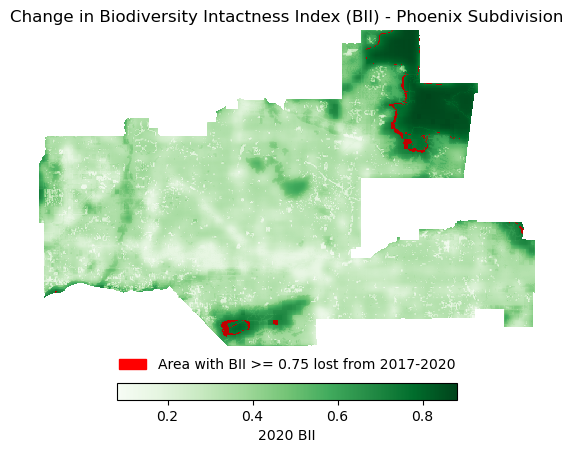

In [10]:
#create plot
fig, ax = plt.subplots()

#plot 2020 raster 
plot2020 = clip_2020.plot(ax=ax, cmap="Greens", add_colorbar = False)
cbar1 = plt.colorbar(plot2020, ax=ax, orientation="horizontal", fraction=0.046, pad=0.1)
cbar1.set_label("2020 BII")

#Rotate colorbar label
cbar1.ax.yaxis.label.set_rotation(270)

#plot subtract raster
im2 = bii_subtract.plot(ax=ax, cmap="gist_heat", add_colorbar=False)

#create patch for subtract raster
subtract_patches = mpatches.Patch(color= "Red", label = "Area with BII >= 0.75 lost from 2017-2020")

#add subtract patch
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles = [subtract_patches], frameon = False, loc = (0.15, -0.1))

#turn off axis and add title
ax.axis("off")
ax.set_title("Change in Biodiversity Intactness Index (BII) - Phoenix Subdivision")

plt.show()

fig.savefig('images/biiphoenix.png')